In [1]:
## ---------------------------
##
## Script name: 6_clustering.ipynb
##
## Purpose of script: Clustering Shaw flu gene expression data
##
## Author: Mamie Wang
##
## Date Created: 2022-06-24
##
## Email: mamie.wang@yale.edu
##
## ---------------------------

## load the packages and functions
suppressPackageStartupMessages({
    library(Seurat)
    library(readxl)
    library(tidyverse)
    library(cowplot)
    library(ComplexHeatmap)
    library(circlize)
})

outdir = "/gpfs/gibbs/pi/kleinstein/shaw_flu/outs/6_clustering/"

## ---------------------------
## IG and TR related genes

load("/gpfs/gibbs/pi/kleinstein/mw957/data/QC_features_meta.RData")
biotypes_excl = unique(features_meta[["gene_biotype"]])[grepl(pattern="^IG_|^TR_", x=unique(features_meta[["gene_biotype"]]))]
remove.genes = features_meta[["external_gene_name"]][features_meta[["gene_biotype"]] %in% biotypes_excl]
remove.genes <- c(remove.genes, 'AC233755.1', 'AC233755.2')

## ---------------------------
## markers
cell_type_markers = c("MS4A1", "CD19", "CD79A", 
                "GZMB", "GNLY", "NKG7", "NCAM1",
                "CD3D", "CD3E", "CD3G", "CD4", "CD8A", "KLRB1", "CTSW",
                "CD14", "LYZ", "CST3", "MS4A7", 
                "IL3RA", "CLEC4C", 
                "CD34",
                "PPBP", "MKI67")


PB <- c("XBP1", "IRF4", "SEC11C", "FKBP11", "JCHAIN", "PRDM1")
naive_B <- c("TCL1A", "IL4R", "CCR7")
ABC <- c("TBX21", "FCRL5", "ZEB2", "ITGAX", "NKG7")
resting_memory <- c("TNFRSF13B", "CD27", "CD24")
dividing <- c("MKI67")
isotype <- c("IGHM", "IGHD", "IGHG1", "IGHG2", "IGHG3", "IGHG4", "IGHA1", "IGHA2", "IGHE")

B_cells_markers = c(naive_B, resting_memory, ABC, PB, dividing, isotype)
other = c("PPBP", "S100A8")

In [2]:
## ---------------------------
## Load data

flu_data = readRDS(file.path(outdir, "GEX_mapped.rds"))

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



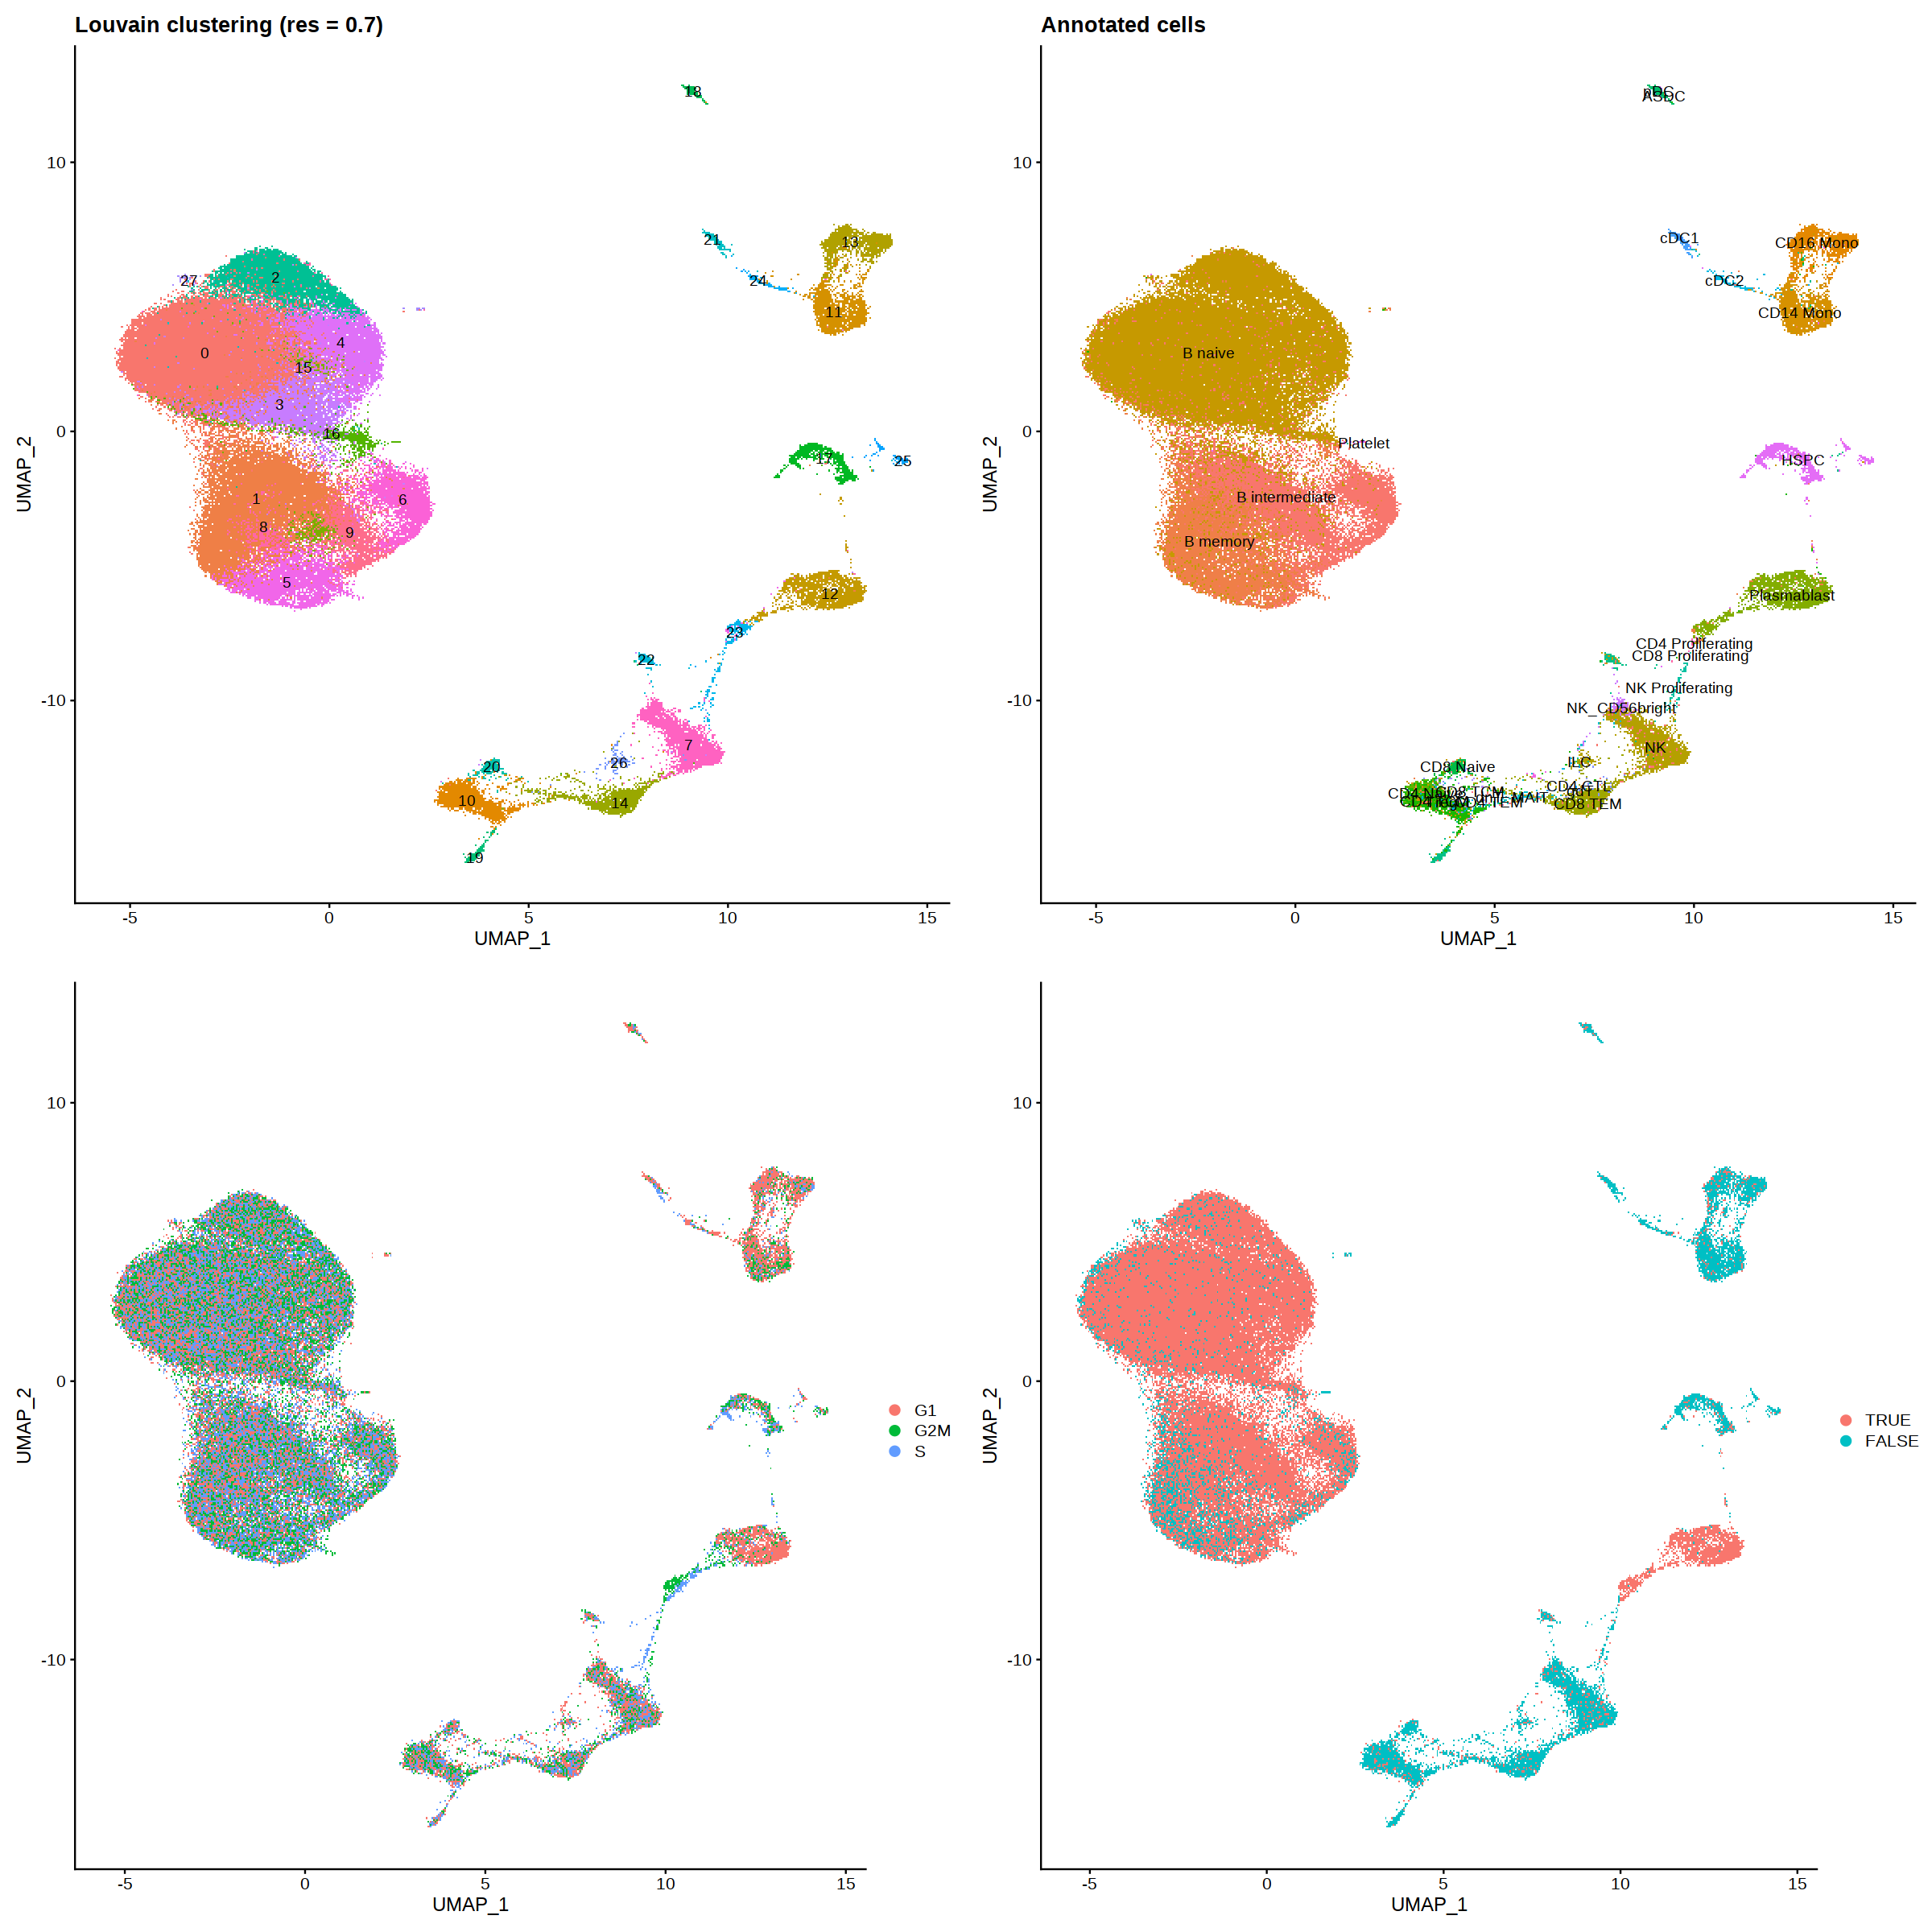

In [189]:
options(repr.plot.width = 20, repr.plot.height = 20)
Idents(flu_data) = "RNA_snn_res.0.7"
p1 = DimPlot(flu_data, label = T) + 
  ggtitle("Louvain clustering (res = 0.7)") + NoLegend()
Idents(flu_data) = "predicted.celltype.l2"
p2 = DimPlot(flu_data, label = T) + 
  ggtitle("Annotated cells") + NoLegend()
Idents(flu_data) = "Phase"
p3 = DimPlot(flu_data, reduction = "umap")
Idents(flu_data) = "has_bcr"
p4 = DimPlot(flu_data, reduction = "umap")

plot_grid(p1, p2, p3, p4, ncol = 2)

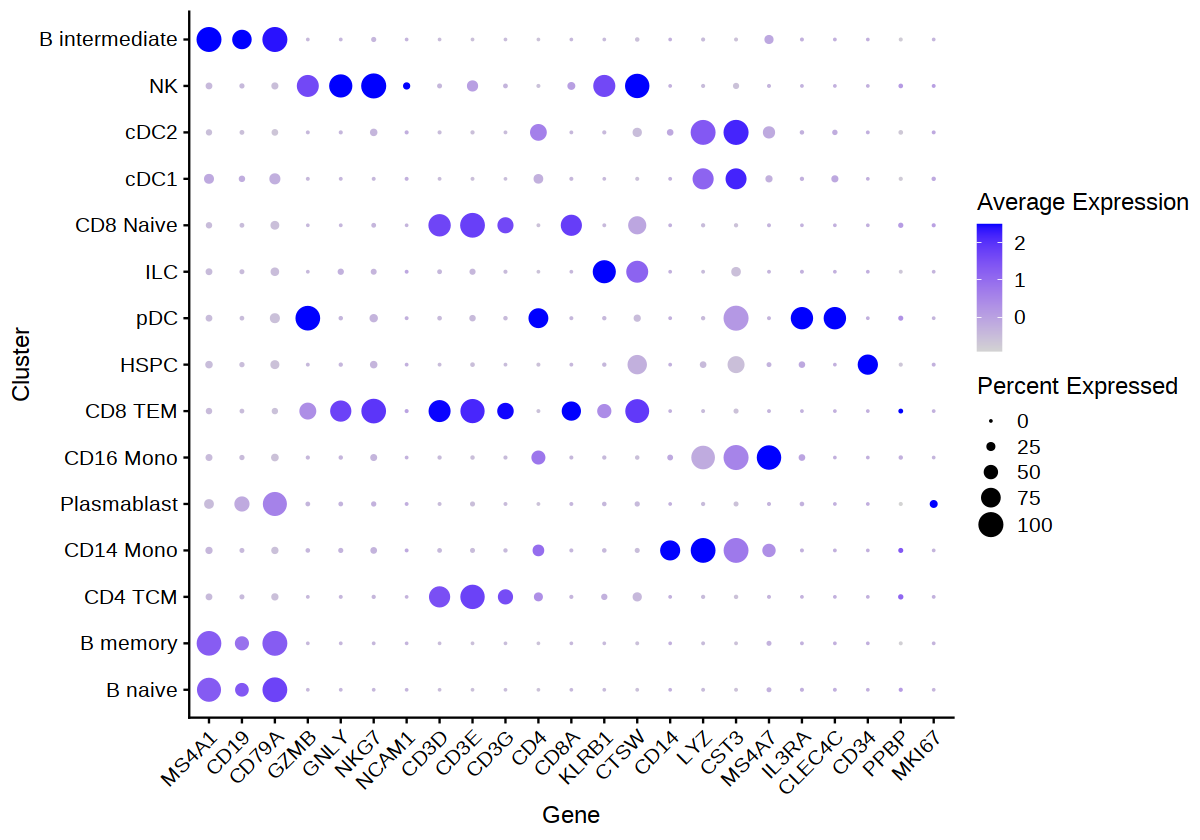

In [127]:
options(repr.plot.width = 10, repr.plot.height = 7)
DotPlot(flu_data, features = cell_type_markers, group.by = "annotated_cluster", 
        assay = "RNA", scale.by = "radius") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  xlab("Gene") +
  ylab("Cluster")

In [85]:
anno = as.matrix(table(flu_data$RNA_snn_res.0.7, 
                       flu_data@meta.data$predicted.celltype.l2))
options(repr.plot.width = 10, repr.plot.height = 6)
mcc_col = colorRamp2(c(0, 500, 1000), c("steelblue", "white", "orange"))
ha = Heatmap(anno, col = mcc_col, cluster_rows = T, cluster_columns = T, 
             name = "counts")
ha

In [118]:
##-----------------------------
## Counts 


tab = table(as.character(flu_data$annotated_cluster), flu_data$has_bcr)
tab
prop.table(tab, margin = 1)

[1] 117278

                
                 FALSE  TRUE
  B intermediate   855  6277
  B memory        4818 19753
  B naive         4939 61835
  CD14 Mono       1942   253
  CD16 Mono       1713   256
  CD4 TCM         2197   314
  CD8 Naive        396    48
  CD8 TEM         1740   209
  cDC1             390   124
  cDC2             262    24
  HSPC            1098   160
  ILC              749    85
  NK              3321   449
  pDC              539    78
  Plasmablast      141  2313

                
                      FALSE       TRUE
  B intermediate 0.11988222 0.88011778
  B memory       0.19608482 0.80391518
  B naive        0.07396591 0.92603409
  CD14 Mono      0.88473804 0.11526196
  CD16 Mono      0.86998476 0.13001524
  CD4 TCM        0.87495022 0.12504978
  CD8 Naive      0.89189189 0.10810811
  CD8 TEM        0.89276552 0.10723448
  cDC1           0.75875486 0.24124514
  cDC2           0.91608392 0.08391608
  HSPC           0.87281399 0.12718601
  ILC            0.89808153 0.10191847
  NK             0.88090186 0.11909814
  pDC            0.87358185 0.12641815
  Plasmablast    0.05745721 0.94254279

## B cells QC

In [7]:
B = readRDS(file.path(outdir, "B.rds"))

In [16]:
## ---------------------------
## Rennotate the clusters
options(repr.plot.width = 15, repr.plot.height = 6)

Idents(B) <- "RNA_snn_res.2"
p1 = DimPlot(B,reduction = "umap", label = T) + NoLegend()
p2 = DotPlot(B, features = c(B_cells_markers, other), 
        assay = "RNA", scale.by = "radius") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  xlab("Gene") +
  ylab("Cluster")

plot_grid(p1,  p2, ncol = 2, rel_widths = c(1.5, 3))

In [70]:
anno = as.matrix(table(B$RNA_snn_res.2, B@meta.data$predicted.celltype.l2))
cluster_anno = colnames(anno)[apply(anno, 1, which.max)] # by majority vote

Idents(B) = "RNA_snn_res.2"
names(cluster_anno) <- levels(B$RNA_snn_res.2)
B <- RenameIdents(B, cluster_anno)
B$annotated_cluster = Idents(B) 

azimuth_anno = table(B$`RNA_snn_res.2`, B$annotated_cluster) %>% 
  data.frame %>% 
  filter(Freq > 0) %>%
  arrange(Var2) %>%
  mutate(Var1 = as.character(Var1), Var2 = as.character(Var2))

modified_anno = azimuth_anno

modified_anno$Var2[modified_anno$Var1 %in% c(6, 8, 18, 24)] = "B memory"
modified_anno$Var2[modified_anno$Var1 == 27] = "PB proliferating"
modified_anno$Var2 = plyr::mapvalues(modified_anno$Var2, 
                                    from = c("B intermediate", "B memory", "B naive", "Plasmablast", "PB proliferating"), 
                                    to = c("ABC", "RMB", "Naive B", "PB", "PB proliferating"))

In [71]:
B$annotated_cluster <- plyr::mapvalues(as.character(B$RNA_snn_res.2),
                                       from = as.character(modified_anno$Var1),
                                       to = as.character(modified_anno$Var2))

table(B$annotated_cluster)


             ABC          Naive B               PB PB proliferating 
            6336            62197             1944              337 
             RMB 
           19319 

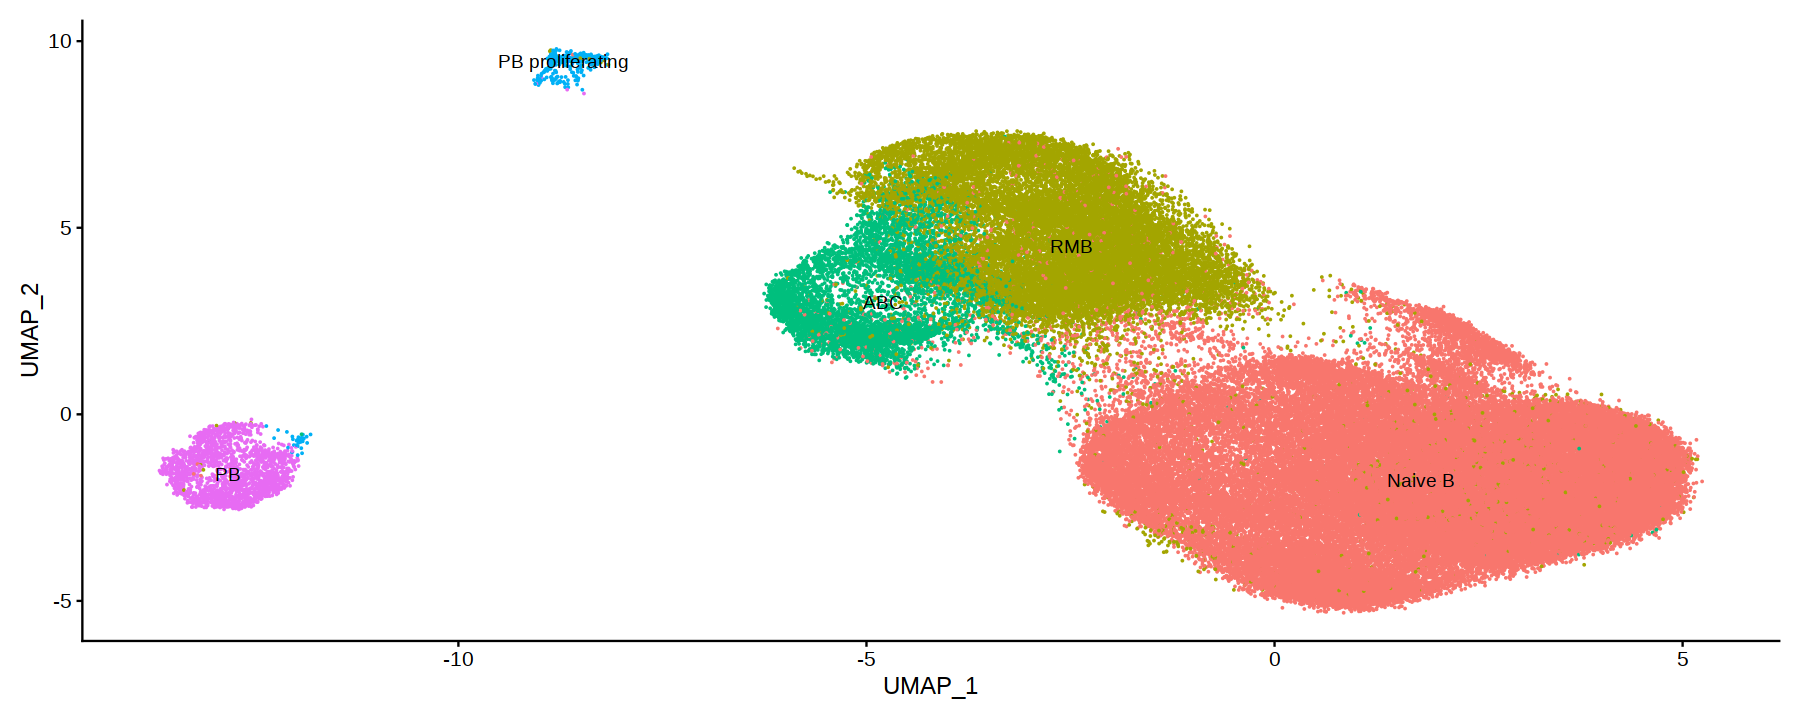

In [72]:
Idents(B) = "annotated_cluster"
DimPlot(B,reduction = "umap", label = T) + NoLegend()

In [73]:
prop.table(table(B$predicted.celltype.l2, B$sample), margin = 2)

                
                    120648_0    120648_7    120667_0    120667_7    141393_0
  B intermediate 0.166206134 0.172607602 0.107435138 0.116311271 0.211363636
  B memory       0.138297872 0.136222452 0.126240641 0.099279978 0.238409091
  B naive        0.684995855 0.679337376 0.738464217 0.742038217 0.521363636
  Plasmablast    0.010500138 0.011832569 0.027860003 0.042370534 0.028863636
                
                    141393_7    141394_0    141394_7    141409_0    141409_7
  B intermediate 0.245158350 0.168632894 0.205394774 0.156044644 0.172605791
  B memory       0.173160173 0.042232577 0.039196403 0.165745280 0.121380846
  B naive        0.539530645 0.779121642 0.741921888 0.656722645 0.595291123
  Plasmablast    0.042150832 0.010012888 0.013486935 0.021487431 0.110722240
                
                    141415_0    141415_7
  B intermediate 0.160636351 0.162204059
  B memory       0.087216669 0.066375423
  B naive        0.748486555 0.748167982
  Plasmablast  

In [74]:
prop.table(table(B$annotated_cluster, B$sample), margin = 2)

                  
                       120648_0     120648_7     120667_0     120667_7
  ABC              0.0428295109 0.0511758616 0.0421382553 0.0412628081
  Naive B          0.6855484941 0.6663215501 0.7032909629 0.7118526724
  PB               0.0092567007 0.0105014051 0.0201985025 0.0378011631
  PB proliferating 0.0013815971 0.0014790711 0.0076615010 0.0047078372
  RMB              0.2609836972 0.2705221121 0.2267107783 0.2043755192
                  
                       141393_0     141393_7     141394_0     141394_7
  ABC              0.1397727273 0.1891091365 0.1159908793 0.1624051700
  Naive B          0.5040909091 0.5224424698 0.8071775553 0.7441697106
  PB               0.0240909091 0.0341763500 0.0067413503 0.0105366676
  PB proliferating 0.0059090909 0.0082023240 0.0035689501 0.0033717336
  RMB              0.3261363636 0.2460697198 0.0665212650 0.0795167182
                  
                       141409_0     141409_7     141415_0     141415_7
  ABC              0